# Create a passive aggressive classifier to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

from sklearn.linear_model import PassiveAggressiveClassifier

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

*Please look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html).*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53.*

## Load Data

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

In [4]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

In [5]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 2min 39s, sys: 1.23 s, total: 2min 40s
Wall time: 2min 40s


In [6]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 2min 14s, sys: 2.42 s, total: 2min 16s
Wall time: 2min 16s


In [7]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53'

In [8]:
y = Y[GENE]

In [9]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: TP53, dtype: int64

In [10]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.655334
1    0.344666
Name: TP53, dtype: float64

## Set aside 10% of the data for testing

In [11]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,501 features, 6,935 training samples, 771 testing samples'

## Specify Model Features

In [12]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500

param_fixed = {
    'fit_intercept': True,
    'random_state' : 0
}

# Lower 'C' means more regularization.

param_grid = {
    'loss'  : ['hinge', 'squared_hinge'],
    'C': [10**x for x in np.linspace(-8, 1, 10)]
    
}

## Median absolute deviation feature selection

In [13]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline, and cross validation model fitting

In [14]:
# clf is Classifier
clf = PassiveAggressiveClassifier(fit_intercept=param_fixed['fit_intercept'], random_state=param_fixed['random_state'], n_iter=8)

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370

warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')

pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [15]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

CPU times: user 10.7 s, sys: 5.52 s, total: 16.2 s
Wall time: 26.5 s


In [16]:
clf_grid.best_params_

{'C': 0.0001, 'loss': 'squared_hinge'}

In [17]:
best_clf

PassiveAggressiveClassifier(C=0.0001, class_weight=None, fit_intercept=True,
              loss='squared_hinge', n_iter=8, n_jobs=1, random_state=0,
              shuffle=True, verbose=0, warm_start=False)

## History of best parameters/testing

In [18]:
# Best params

# {'C': 0.0001, 'loss': 'squared_hinge'}
# {'C': 0.0001, 'loss': 'squared_hinge'}

## Visualize hyperparameters performance

In [19]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [20]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

/home/ktt/anaconda2/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,C,fold,loss,score
0,1.000000e-08,0,hinge,0.725891
1,1.000000e-08,1,hinge,0.723908


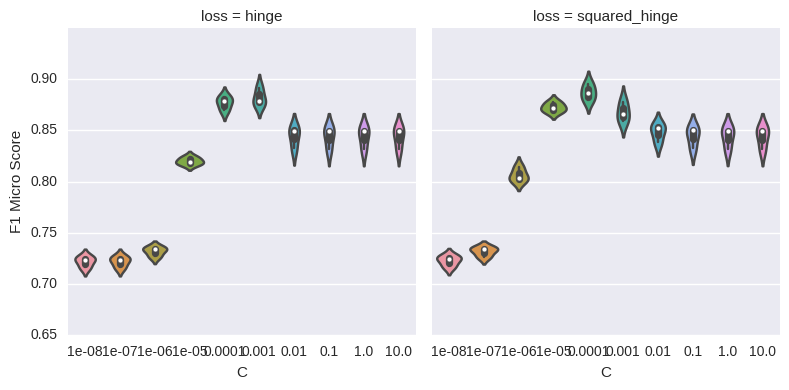

In [21]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='C', y='score', col='loss',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('F1 Micro Score');

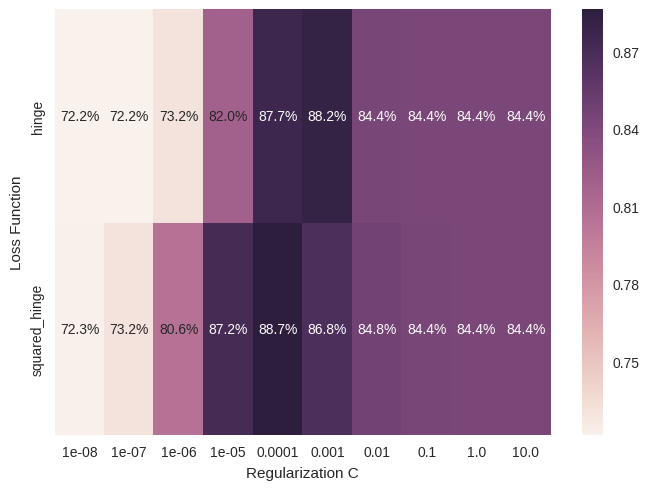

In [22]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='loss', columns='C')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization C')
ax.set_ylabel('Loss Function');

## Use Optimal Hyperparameters to Output ROC Curve

In [23]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

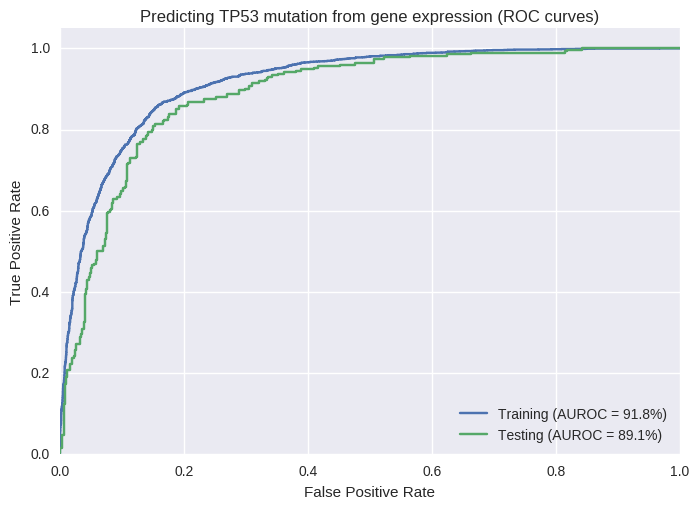

In [24]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [25]:
coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X.columns[feature_mask], columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [26]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'0.0% zero coefficients; 254 negative and 246 positive coefficients'

In [27]:
coef_df.head(10)

,weight,abs
GPR158,0.113508,0.113508
MMP7,0.107662,0.107662
AFF3,-0.104954,0.104954
MLXIPL,0.104354,0.104354
HES2,-0.104140,0.104140
ATP10B,0.098427,0.098427
PVRL4,-0.092459,0.092459
FUT3,0.085685,0.085685
VTCN1,0.084200,0.084200
EDN2,-0.082313,0.082313


## Investigate the predictions

In [28]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X))
])

In [29]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function
sample_id,,,,
TCGA-CQ-A4CI-01,TCGA-CQ-A4CI-01,0,0,1.459431
TCGA-CV-5441-01,TCGA-CV-5441-01,1,0,1.400267
TCGA-49-6743-01,TCGA-49-6743-01,1,0,1.387088
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,1.250359
TCGA-55-6978-01,TCGA-55-6978-01,0,0,1.151535
TCGA-GV-A40E-01,TCGA-GV-A40E-01,1,0,1.103204
TCGA-B6-A0I1-01,TCGA-B6-A0I1-01,0,0,1.102869
TCGA-CV-7261-01,TCGA-CV-7261-01,0,0,1.073544
TCGA-46-3765-01,TCGA-46-3765-01,0,0,1.073419


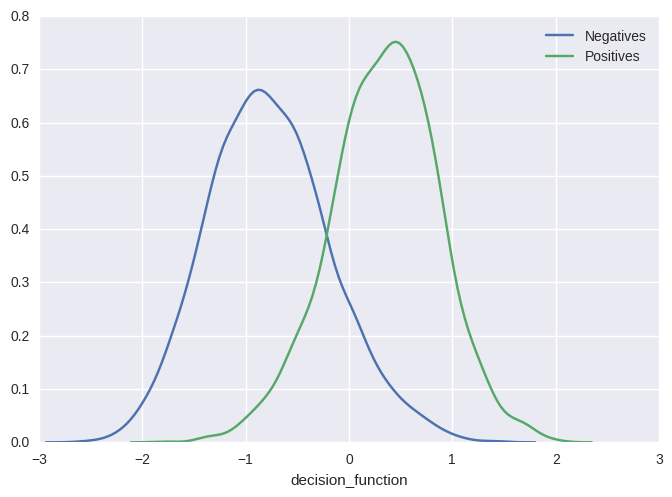

In [30]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')